In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from glob import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

os.chdir(os.path.dirname("../src/"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from albumentations.pytorch import ToTensor

In [5]:
from siim_pneumothorax.utils import parse_dicom
from siim_pneumothorax.utils import ConfigObject
from siim_pneumothorax.dataset import get_pneumo_loaders
from siim_pneumothorax.losses import Dice_metric
from siim_pneumothorax.losses import IoU_metric
from siim_pneumothorax.losses import MixedLoss
from siim_pneumothorax.losses import MixedFocalLoss
from siim_pneumothorax.losses import DiceLoss
from siim_pneumothorax.losses import FocalLoss
from siim_pneumothorax.models import VanillaUNet

In [6]:
import segmentation_models_pytorch as smp

# Configuration

In [7]:
params = {
    # Loader parameters
    'loader_params': {
        'img_size': 256,
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 8,
        'rgb_channel': False
    },
    
    # Loss/metric parameters
    'alpha': 10,
    'gamma': 2,
    'smooth': 1,
    
    # training parameters
    'n_folds': 3,
    'num_epochs': 50,
    'checkpoint_path': '../models/model_checkpoint',
    'model_save_path': '../models/last_model'
}

# Data preparation

In [8]:
train_fns = sorted(glob('../data/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('../data/siim/dicom-images-test/*/*/*.dcm'))

In [9]:
train_rle_codes = pd.read_csv('../data/siim/train-rle.csv')
train_rle_codes.columns = ["ImageId", "EncodedPixels"]
train_rle_codes['has_pneumothorax'] = (train_rle_codes.EncodedPixels != "-1").astype(int)

In [10]:
train_dataset = pd.DataFrame([parse_dicom(x, train_rle_codes) for x in  train_fns])

In [11]:
test_dataset = pd.DataFrame([parse_dicom(x, is_training=False) for x in  test_fns])

In [12]:
train_dataset.dropna(inplace=True)

In [13]:
# train_dataset = train_dataset.sample(80)

# Model, Loss function, Optimizer and LR Scheduler

In [14]:
def get_parameters(params):
    device = 'cuda'
    model = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=1)
    model = model.to(device)
    
    # Build optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    
    # LR scheduler
    lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=params["num_epochs"], eta_min=1e-4
    )

    m_loss = MixedLoss(params['smooth'])
    
    return device, model, optimizer, lr_scheduler, m_loss

# Setup Execution

In [15]:
def train(config, model, train_loader, valid_loader, 
          loss_fn, lr_scheduler, optimizer, device, debug=True):

    history = {
        'loss': [], 'val_loss': [], 'dice': [], 
        'val_dice': [], 'iou': [], 'val_iou': []
    }
    
    dice_metric = Dice_metric()
    iou_metric = IoU_metric()
    
    for epoch in range(config.num_epochs):
        loss, dice, iou = 0.0, [], []

        start_time = time.time()
        model.train()
        
        for idx, (img, mask) in enumerate(train_loader):
            img = img.type(torch.FloatTensor).to(device)
            mask = mask.type(torch.FloatTensor).to(device)
            optimizer.zero_grad()
            recon_batch = model(img)
            loss_batch = loss_fn(recon_batch, mask)
            dice_batch = dice_metric(recon_batch, mask)
            iou_batch = iou_metric(recon_batch, mask)
            
            loss_batch.backward()
            optimizer.step()

            # Compute metrics to all batch
            loss += loss_batch.item()*len(img)
            dice.append(dice_batch.item())
            iou.append(iou_batch.item())

            if debug:
                print("step: {:4d} of {:4d} | loss: {:.4f} | dice: {:.4f} | iou: {:.4f} ".format(idx + 1, len(train_loader),
                    loss_batch.item()*len(img), dice_batch.item(), iou_batch.item()), end='\r')

        loss /= len(train_loader)
        dice = np.nanmean(dice)
        iou = np.nanmean(iou)

        val_loss, val_dice, val_iou, comparison = evaluate(config, model, valid_loader, loss_fn, device)
        lr_scheduler.step()
        elapsed_time = time.time() - start_time
        
        # Display training Metrics
        print('====> Epoch: {:02d} Loss: {:.3f} | val_loss: {:.3f} | val_dice: {:.3f} | val_iou: {:.3f} | Elapsed time: {:.4f}'.format(
          epoch+1, loss, val_loss, val_dice, val_iou, elapsed_time))
        
        # Compute the statistics of the last epoch and save to history
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['dice'].append(dice)
        history['val_dice'].append(val_dice)
        history['iou'].append(iou)
        history['val_iou'].append(val_iou)

        # Checkpoint the model
        torch.save(model.state_dict(), config.checkpoint_path)
        
    return history

In [16]:
def evaluate(config, model, heldout_loader, loss_fn, device):
    model.eval()
    heldout_loss = 0
    heldout_dice = []
    heldout_iou = []
    
    dice_metric = Dice_metric()
    iou_metric = IoU_metric()

    with torch.no_grad():
        for i, (img, mask) in enumerate(heldout_loader):
            img = img.type(torch.FloatTensor).to(device)
            mask = mask.type(torch.FloatTensor).to(device)
            recon_batch = model(img)
            heldout_loss += loss_fn(recon_batch, mask).item()*len(img)
            heldout_dice.append(dice_metric(recon_batch, mask).item())
            heldout_iou.append(iou_metric(recon_batch, mask).item())

    heldout_loss /= len(heldout_loader)
    heldout_dice = np.nanmean(heldout_dice)
    heldout_iou = np.nanmean(heldout_iou)
    
    n = min(img.size(0), 16)
    comparison = [img[:n], recon_batch[:n], mask[:n]]
    
    return heldout_loss, heldout_dice, heldout_iou, comparison

In [17]:
def KFoldTrainer(dataset, params):
    metrics = []
    skf = StratifiedKFold(n_splits=params['n_folds'])

    # Start kFold
    for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset['has_pneumothorax'])):
        print("======= Fold {}/{} =======".format(fold+1, params['n_folds']))
        train_dataset, val_dataset = dataset.iloc[train_index], dataset.iloc[val_index]
        
        # Balance the dataset
        g = train_dataset.groupby('has_pneumothorax')
        train_dataset = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
        
        # Configure parameters
        config = {
            'smooth': params["smooth"],
            'num_epochs': params['num_epochs'],
            'checkpoint_path': '{}.pt'.format(params['checkpoint_path']),
            'model_save_path': '{}_fold_{}.pt'.format(params['model_save_path'], fold)
        }

        # Create data loaders
        train_loader = get_pneumo_loaders(df=train_dataset, is_train=True, **params['loader_params'])
        val_loader = get_pneumo_loaders(df=val_dataset, is_train=False, **params['loader_params'])

        # Start training
        config = ConfigObject(**config)
        device, model, optimizer, lr_scheduler, m_loss = get_parameters(params)
        history = train(
            config, model, train_loader, val_loader, 
            m_loss, lr_scheduler, optimizer, device, debug=True
        )

        metrics.append(history)
        torch.save(model.state_dict(), config.model_save_path)
        print("") # Break line

    return metrics

# Train

In [18]:
history = KFoldTrainer(train_dataset, params)

======= Fold 1/3 =======
====> Epoch: 01 Loss: 17.624 | val_loss: 16.131 | val_dice: 0.046 | val_iou: 0.778 | Elapsed time: 68.7298
====> Epoch: 02 Loss: 15.461 | val_loss: 15.112 | val_dice: 0.084 | val_iou: 0.778 | Elapsed time: 70.1104
====> Epoch: 03 Loss: 14.820 | val_loss: 14.444 | val_dice: 0.127 | val_iou: 0.778 | Elapsed time: 70.4464
====> Epoch: 04 Loss: 14.480 | val_loss: 14.600 | val_dice: 0.119 | val_iou: 0.778 | Elapsed time: 70.5603
====> Epoch: 05 Loss: 14.366 | val_loss: 13.606 | val_dice: 0.175 | val_iou: 0.778 | Elapsed time: 70.4321
====> Epoch: 06 Loss: 14.100 | val_loss: 13.724 | val_dice: 0.173 | val_iou: 0.778 | Elapsed time: 70.5320
====> Epoch: 07 Loss: 13.953 | val_loss: 13.897 | val_dice: 0.167 | val_iou: 0.778 | Elapsed time: 70.4906
====> Epoch: 08 Loss: 13.990 | val_loss: 14.394 | val_dice: 0.151 | val_iou: 0.778 | Elapsed time: 70.5607
====> Epoch: 09 Loss: 13.752 | val_loss: 13.452 | val_dice: 0.186 | val_iou: 0.778 | Elapsed time: 70.6140
====> Epoch:

# Performance Report

In [19]:
print("Loss = mean: {:.3f} | std: {:.3f}".format(
    np.mean([d['val_loss'][-1] for d in history]),
    np.std([d['val_loss'][-1] for d in history])
))

Loss = mean: 10.543 | std: 0.258


In [20]:
print("Dice = mean: {:.3f} | std: {:.3f}".format(
    np.mean([d['val_dice'][-1] for d in history]),
    np.std([d['val_dice'][-1] for d in history])
))

Dice = mean: 0.361 | std: 0.016


In [21]:
print("IoU = mean: {:.3f} | std: {:.3f}".format(
    np.mean([d['val_iou'][-1] for d in history]), 
    np.std([d['val_iou'][-1] for d in history])
))

IoU = mean: 0.778 | std: 0.000


# Visualization

In [22]:
model = smp.Unet('resnet34', encoder_weights='imagenet', in_channels=1)
model.load_state_dict(torch.load('../models/last_model_fold_0.pt'))
model = model.to('cuda')

In [23]:
train_loader = get_pneumo_loaders(df=train_dataset[train_dataset.has_pneumothorax == 1], is_train=False, **params['loader_params'])

In [24]:
with torch.no_grad():
    for img, mask in train_loader:
        img = img.to('cuda')
        predicted_mask = model(img)
        break

tensor(804.)

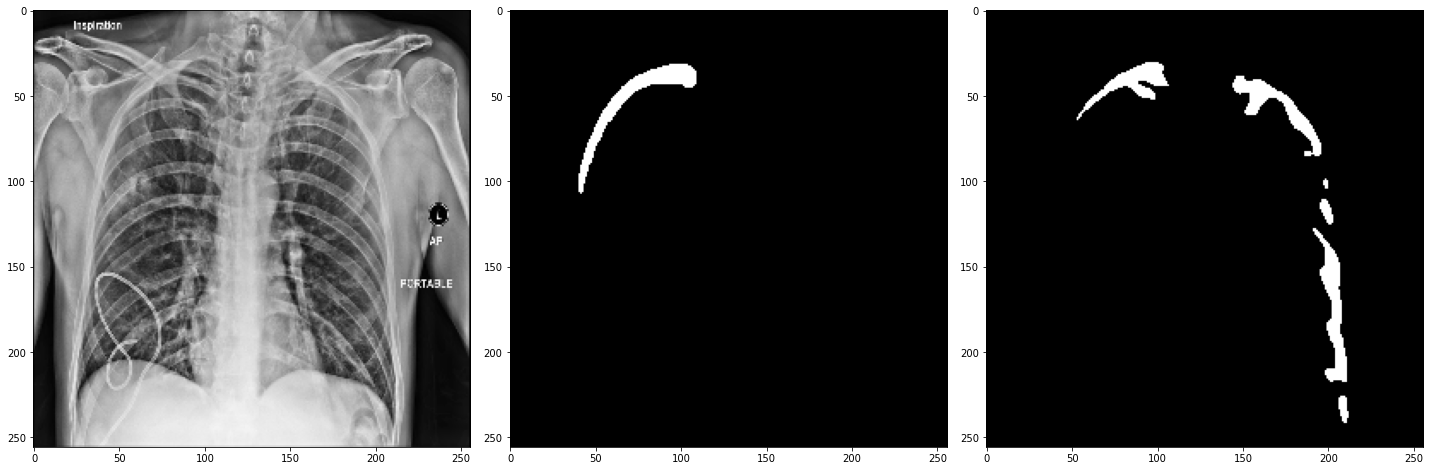

In [25]:
idx = 8

p_mask = (nn.Sigmoid()(predicted_mask[idx][0, :, :]).cpu() > .5).int()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
axes[0].imshow(img[idx, 0, :, :].cpu(), cmap='gray')
axes[1].imshow(mask[idx, 0, :, :], cmap='gray')
axes[2].imshow(p_mask, cmap='gray')
plt.tight_layout()